# Hughes stabilized mixed finite element method for Darcy flow
---

In [1]:
from firedrake import *
import numpy as np
import random
try:
    import matplotlib.pyplot as plt
except:
    warning("Matplotlib not imported")

## Create a mesh

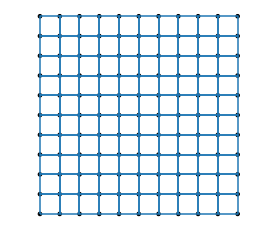

In [2]:
nx, ny = 10, 10
Lx, Ly = 1.0, 1.0
mesh = RectangleMesh(nx, ny, Lx, Ly, quadrilateral=True)
plot(mesh)
plt.axis('off')
plt.show()

## Function spaces

In [3]:
degree = 1
velSpace = VectorFunctionSpace(mesh, 'CG', degree)
pSpace = FunctionSpace(mesh, 'CG', degree)
wSpace = MixedFunctionSpace([velSpace, pSpace])

kSpace = FunctionSpace(mesh, "DG", 0)

## Defining trial and test functions

In [4]:
(v, p) = TrialFunctions(wSpace)
(w, q) = TestFunctions(wSpace)
solution = Function(wSpace)
n = FacetNormal(mesh)

## Source term

In [5]:
class f_0(Expression):
    def eval(self, values, x):
        values[0] = sin(2. * pi * x[0] / Lx) * sin(2.* pi * x[1] / Ly)

121


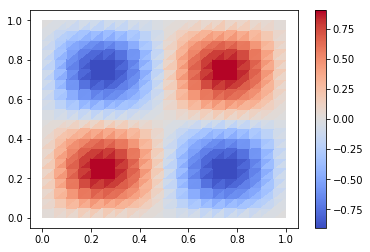

In [18]:
x = SpatialCoordinate(mesh)
V_a = FunctionSpace(mesh, "CG", degree + 3)
U_a = VectorFunctionSpace(mesh, "CG", degree + 3)

u_a = Function(V_a, name="Analytic Scalar")
a_scalar = sin(2. * pi * x[0]) / Lx * sin(2.* pi * x[1]) / Ly
# u_a.interpolate(a_scalar)

# f = Function(pSpace).interpolate(-div(grad(a_scalar)))

q_a = Function(U_a, name="Analytic Flux")
a_flux = -grad(a_scalar)

f = interpolate(f_0(), pSpace)
f_v = interpolate(a_flux, velSpace)

# f1 = Function(pSpace).interpolate(-div(grad(conc_k)))

# print(conc_v.dof_dset)

print(f.dof_dset.set.size)
# q_a.project(a_flux)

# return a_scalar, a_flux, u_a, q_a
plot(f)
plt.show()

## Boundary condition

In [7]:
bcDPP = []

In [8]:
p_bound = Constant(0.0)
bcall = DirichletBC(pSpace, p_bound, 1, method = 'geometric')
bcDarcy = [bcall]

## Physical parameters

In [9]:
K = Constant(1.0)
K_inv = inv(K)

## Variational form

In [10]:
B = inner(K_inv * v, w) * dx + \
    - div(w) * p * dx + div(v) * q * dx  \

B_stab = 0.5 * inner(K_inv * (K * v + grad(p)), - K_inv * w + grad(q)) * dx

In [11]:
LHS = B + B_stab

In [12]:
rhob = Constant((0.0, 0.0))

In [14]:
L = - dot(w, rhob) * dx + q * f * dx + Constant(0.0) * dot(w, n) * ds

In [15]:
L_stab = - 0.5 * inner(K * rhob, - K_inv * w + grad(q)) * dx

In [16]:
RHS = L + L_stab